PyImageJ Tutorial
===

This notebook covers how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including NumPy, SciPy, scikit-image, CellProfiler, OpenCV, ITK and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the other notebooks.

## 3 Converting to Java: `ij.py.to_java()`

The function `ij.py.to_java()` is capable of converting common Python and NumPy data types into their Java/ImageJ equivalent. There is one important nuance; converting a NumPy array to Java creates a Java object that points to the NumPy array. This means that **changing the Java object also changes the NumPy array**.

### 3.1 Converting between Java and Python

Converting between Java and Python is done using the `ij.py.to_java()` and `ij.py.from_java()` functions. For more information about `ij.py.from_java()`, checkout the next notebook: [4-Retrieving-Data-from-Java](../doc/4-Retrieving-Data-from-Java.ipynb). A table of common data types and their converted types is listed below.

| Python object                   | Java Object                                                    |
|---------------------------------|----------------------------------------------------------------|
| `numpy.ndarray`                 | `net.imglib2.python.ReferenceGuardingRandomAccessibleInterval` |
| `xarray.DataArray`              | `net.imagej.Dataset`                                           |
| `str`                           | `java.lang.String`                                             |
| `int`                           | `java.lang.Integer`                                            |
| `float`                         | `java.lang.Float`                                              |
| `list`                          | `java.util.ArrayList`                                          |
| `dict`                          | `java.util.LinkedHashMap`                                      |
| `tuple`                         | `java.util.ArrayList`                                          |

**NumPy and xarrays are linked to Java equivalents** 

`ij.py.to_java()` is capable of converting common Python and numpy data types into their Java/ImageJ/ImageJ2 equivalent. There is one important nuance; converting a `numpy.ndarray` or `xarray.DataArray` to Java creates a Java object that points to the numpy array. **This means that changing the Java object also changes the numpy array.**

### 3.2 Converting Python objects to Java
We can see how `ij.py.to_java()` works to convert Python objects to Java. In this section we will convert lists as an example. First we need to initialize ImageJ:

In [1]:
import imagej

# initialize ImageJ in interactive mode
ij = imagej.init(mode='interactive')
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.3.0/1.53f


Now lets look at how to convert a Python list to Java. Modifying either list demonstrates how lists are not linked, unlike `numpy.ndarray`/`xarray.DataArray`s with their respective Java object.

In [2]:
# create lists
python_list = [1, 2, 3, 4]
java_list = ij.py.to_java(python_list)

# modify one list
python_list[0] = 4

# check list contents
print(f"python_list: {python_list}\njava_list: {java_list}")

python_list: [4, 2, 3, 4]
java_list: [1, 2, 3, 4]


A Java list can be accessed the same way as a Python list.

In [3]:
print("List values:")
for i in range(len(python_list)):
    print(f"python: {python_list[i]}, java: {java_list[i]}")

List values:
python: 4, java: 1
python: 2, java: 2
python: 3, java: 3
python: 4, java: 4


**Note:** `ij.py.to_java()` is not the only way to create a Java list/arrray. You can specifically create Java arrays by calling `JPype`'s `JArray` and `JInt`:

In [4]:
from jpype import JArray, JInt

java_int_array = JArray(JInt)([1, 2, 3, 4])

print(f"type: {type(java_int_array)}\nvalue: {java_int_array}")

type: <java class 'int[]'>
value: [1, 2, 3, 4]


For more information on creating/working with generic Java objects visit JPype's documentation [here](https://jpype.readthedocs.io/en/latest/).

### 3.3 Converting NumPy arrays to Java

NumPy arrays become `RandomAccessibleInterval`s (wrapped as a `net.imglib2.img.ImgView`) and can substitute for `IterableInterval`s.

In [5]:
import numpy as np

# get numpy array and list
test_arr = np.array([[5, 12], [21, 32]])
test_list = [1, 2, 4, 8, 16, 32, 64]

# convert array and list to Java
jarr = ij.py.to_java(test_arr)
jlist = ij.py.to_java(python_list)

print(type(jarr))
print(type(jlist))

<java class 'net.imglib2.img.ImgView'>
<java class 'java.util.ArrayList'>


We can check that `jarr` is a `RandomAccessibleInterval` by checking it against the Java class with `isinstance`. By contrast `jlist` should evaluate as `False` as it is not a `RandomAcessibleInterval`.

In [6]:
import scyjava as sj

# import RandomAccessibleInterval class
RandomAccessibleInterval = sj.jimport('net.imglib2.RandomAccessibleInterval')

print(f"jarr: {isinstance(jarr, RandomAccessibleInterval)}")
print(f"jlist: {isinstance(jlist, RandomAccessibleInterval)}")

jarr: True
jlist: False


`ij.py.to_java()` also works to convert NumPy arrays into ImageJ types. Let's grab an image:

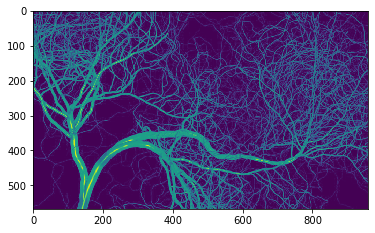

In [7]:
# Import an image with scikit-image.
# NB: Blood vessel image from: https://www.fi.edu/heart/blood-vessels
from skimage import io

url = 'https://www.fi.edu/sites/fi.live.franklinds.webair.com/files/styles/featured_large/public/General_EduRes_Heart_BloodVessels_0.jpg'
img = io.imread(url)
img = np.mean(img, axis=2)

# show image
ij.py.show(img)

Any `Op` that requires a `RandomAccessibleInterval` can run on a NumPy array that has been passed to `to_java()`. Remember that this method creates a `view`, meaning that the `Op` is **modifying** the underlying Python object:

Let's run a [Difference of Gaussians](https://en.wikipedia.org/wiki/Difference_of_Gaussians) on our numpy image using ImageJ:

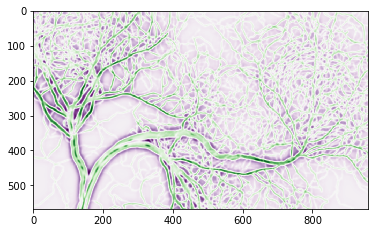

In [8]:
result = np.zeros(img.shape)
# these sigmas will be nice for the larger sections
sigma1 = 8
sigma2 = 2
# note the use of to_java on img and result to turn the numpy images into RAIs
ij.op().filter().dog(ij.py.to_java(result), ij.py.to_java(img), sigma1, sigma2)
# purple highlights the edges of the vessels, green highlights the centers
ij.py.show(result, cmap = 'PRGn')